In [4]:
from napari_convpaint.conv_paint_model import ConvpaintModel
import numpy as np
import matplotlib.pyplot as plt
import skimage

# Using Convpaint programmatically (API)

## Loading a saved model and using it in a loop

In one example workflow you might have interactively trained the model in the Napari GUI, and now want to use it programmatically in batch processing.
Here we load a model trained on sample data and apply it to an image:

In [ ]:
cpm = ConvpaintModel(model_path="../sample_data/lily_VGG16.pkl")

img = skimage.data.lily() # Load example image
img = np.moveaxis(img, -1, 0) # Move channel axis to first position, this is the convention throughout Convpaint

segmentation = cpm.segment(img)

For a simple illustration we extract the first 3 of the 4 channels of the image and display them as RGB. On the right, we show the predicted classes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..4095].


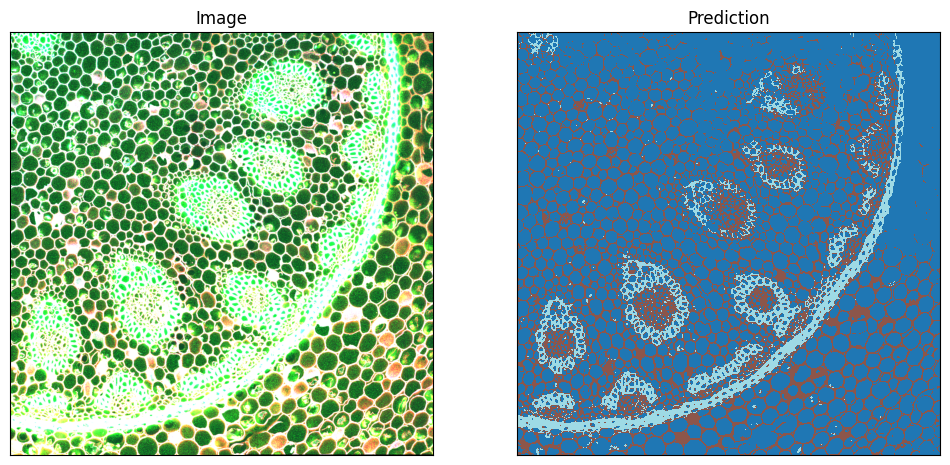

In [ ]:
# Show the image and the annotations next to each other
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the image
axes[0].imshow(skimage.data.lily()[:,:,:3], cmap='gray')
axes[0].set_title('Image')

cmap = plt.get_cmap('tab20', 3)
cmap.set_under('white')

# Plot the prediction
axes[1].imshow(segmentation, cmap=cmap,interpolation='nearest')#,vmin=1,vmax=3)
axes[1].set_title('Prediction')

# Disable x and y ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

## Creating and training a new model using the API

We can also create new models from scratch programatically. Like this, we can easily compare the performance of different models.

First let's look at all the available feature extractors:

In [4]:
ConvpaintModel.get_fe_models_types()

{'vgg16': napari_convpaint.conv_paint_nnlayers.Hookmodel,
 'efficient_netb0': napari_convpaint.conv_paint_nnlayers.Hookmodel,
 'convnext': napari_convpaint.conv_paint_nnlayers.Hookmodel,
 'gaussian_features': napari_convpaint.conv_paint_gaussian.GaussianFeatures,
 'dinov2_vits14_reg': napari_convpaint.conv_paint_dino.DinoFeatures,
 'combo_dino_vgg': napari_convpaint.conv_paint_combo_fe.ComboFeatures,
 'combo_dino_gauss': napari_convpaint.conv_paint_combo_fe.ComboFeatures,
 'combo_dino_ilastik': napari_convpaint.conv_paint_combo_fe.ComboFeatures,
 'vit_small_patch14_reg4_dinov2': napari_convpaint.conv_paint_dino_jafar.DinoJafarFeatures,
 'cellpose_backbone': napari_convpaint.conv_paint_cellpose.CellposeFeatures,
 'ilastik_2d': napari_convpaint.conv_paint_ilastik.IlastikFeatures}

<div class="alert alert-block alert-info">
<b>Tip:</b> It's easy to implement your own feature extractor! Have a look at the file <b>conv_paint_gaussian.py</b> to see a minimal example. We've also provided a template file <b>conv_paint_fe_template.py</b> with instructions - you can copy and modify it to create your own feature extractor.
</div>

When using a CNN such as `VGG16` as feature extractor, we need to supply the layers we want to use.

We can print out the selectable layers like this:

In [5]:
cpm2 = ConvpaintModel()
cpm2.get_fe_layer_keys()

['features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
 'features.2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
 'features.5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
 'features.7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
 'features.10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
 'features.12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
 'features.14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
 'features.17 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
 'features.19 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
 'features.21 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
 'features.24 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
 'features.26 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
 '

By default, we've created a model using `VGG16` with just the first layer for feature extraction:

In [6]:
cpm2.get_param("fe_layers")

['features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))']

<div class="alert alert-block alert-info">
<b>Hint:</b> The layers from VGG16 are filtered to only show layers of type Conv2D. Convpaint adds hooks at the selected layers, i.e. we capture their output. The flow through the network is interrupted at the last selected layer to speed up processing. Each hooked layer returns a certain number of outputs, which are then all concatenated into a single set of features.
</div>

Lets create a new `VGG16` model using the first 2 layers. We store all the necessary settings in the `ConvpaintModel` object, which is also created in the background when using the napari plugin (GUI). Note that the layers can either be specified by names or as indices (among the available layers).

In [7]:
cpm3 = ConvpaintModel(fe_name="vgg16", fe_layers=[0, 1])
cpm3.get_param("fe_layers")

[0, 1]

Besides the layers for CNNs, there are several other options that can be set in the `ConvpaintModel` object:

- `fe_scalings` specifies the levels of downscaling to use for feature extraction (1 is the original size)
- `fe_order` specifies the spline order used to upscale small feature maps (either from the downscaling, or from aggregation in the neural network).
- with `fe_use_min_features=True`, only the n-first features of each output layer are selected, n being the number of features of the layer which outputs the least of them. This can help balance the weight of different layers.
- `normalize` will normalize the image so that it matches more closely the input expected by the pre-trained network.
- `image_downsample` allows to use a smaller version of the image as input. Note that this doesn’t change the size of the predicted output, as it gets rescaled to the original size in the end.

For a **comprehensive description of all parameters and options**, please refer to the [separate page](https://guiwitz.github.io/napari-convpaint/book/Params_settings.html).

Let's **create a custom model**. As you see below, except for the fe_name and layers (and gpu), all parameters can easily be adjusted after initialization - either one at a time, or multiples in one call:

In [ ]:
cpm4 = ConvpaintModel(fe_name="vgg16", fe_layers=[0, 1])
cpm4.set_param("fe_scalings", [1, 2])

Train and test the model on artificial data:

In [17]:
# Create a noisy image
img = np.random.rand(200,200)
factor = 0.5
img[:50,:] = img[:50,:]*factor
img[80:100,:] = img[80:100,:]*factor

# Draw small rectangle as annotations 
annotations = np.zeros((200,200))
annotations[10:30,10:30] = 1      #class 1
annotations[170:190,170:190] = 2  #class 2

# Train the classifier to predict the annotations from the features
cpm4.train(img, annotations)

# Predict the annotations from the image
segmentation = cpm4.segment(img)

0:	learn: 0.5808966	total: 16.8ms	remaining: 1.67s
1:	learn: 0.4642788	total: 25.3ms	remaining: 1.24s
2:	learn: 0.3613301	total: 33.2ms	remaining: 1.07s
3:	learn: 0.2850847	total: 43.5ms	remaining: 1.04s
4:	learn: 0.2367290	total: 50ms	remaining: 951ms
5:	learn: 0.1967113	total: 57.4ms	remaining: 899ms
6:	learn: 0.1642987	total: 65.7ms	remaining: 873ms
7:	learn: 0.1331245	total: 72.1ms	remaining: 829ms
8:	learn: 0.1147539	total: 79.8ms	remaining: 806ms
9:	learn: 0.1012080	total: 86.2ms	remaining: 776ms
10:	learn: 0.0932405	total: 92.5ms	remaining: 749ms
11:	learn: 0.0832472	total: 99.6ms	remaining: 731ms
12:	learn: 0.0712612	total: 106ms	remaining: 710ms
13:	learn: 0.0634873	total: 113ms	remaining: 693ms
14:	learn: 0.0570575	total: 119ms	remaining: 677ms
15:	learn: 0.0535091	total: 126ms	remaining: 663ms
16:	learn: 0.0489758	total: 133ms	remaining: 648ms
17:	learn: 0.0433077	total: 139ms	remaining: 633ms
18:	learn: 0.0397668	total: 145ms	remaining: 618ms
19:	learn: 0.0365790	total: 151

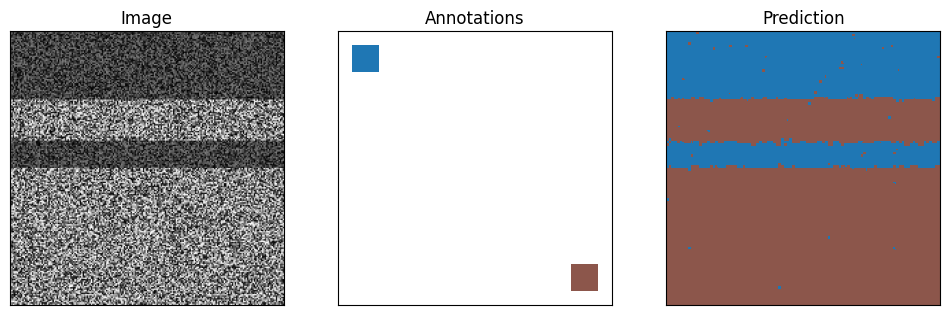

In [18]:
# Show the image and the annotations
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Plot the image
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Image')

cmap = plt.get_cmap('tab20')
cmap.set_under('white')
# Plot the annotations
axes[1].imshow(annotations, cmap=cmap,interpolation='nearest',vmin=1,vmax=3)
axes[1].set_title('Annotations')

# Plot the prediction
axes[2].imshow(segmentation, cmap=cmap,interpolation='nearest',vmin=1,vmax=3)
axes[2].set_title('Prediction')

# Disable x and y ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

The selected output layers have 64 and 64 output features and we're using three scalings, so in total we have `(64+64)*3 = 384` features. With our ConvpaintModel, we can also **extract those features** to display and analyze them further:

Number of features: (256, 200, 200)


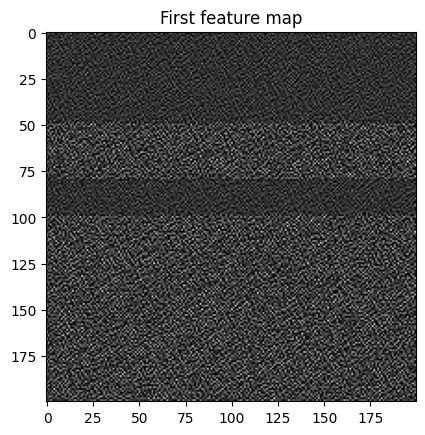

In [19]:
features = cpm4.get_feature_image(img)
print(f"Number of features: {features.shape}")
plt.imshow(features[0], cmap='gray')
plt.title('First feature map')
plt.show()

### Running Convpaint in a loop for batch processing

In [20]:
num_images = 10 # Number of images to generate

imgs = []
segmentations = []

for i in range(num_images):
    # Create a noisy image
    img = np.random.rand(200, 200)
    start_row = np.random.randint(0, 150)
    end_row = start_row + np.random.randint(20, 50)
    img[start_row:end_row, :] = img[start_row:end_row, :] * 0.5
    
    # Make prediction
    segmentation = cpm4.segment(img)
    
    imgs.append(img)
    segmentations.append(segmentation)

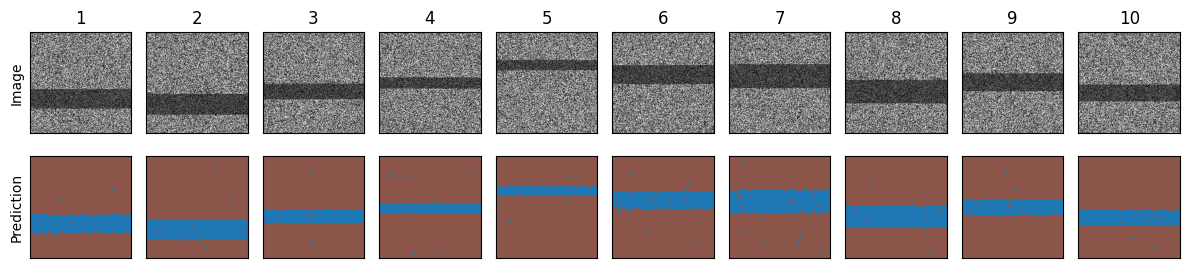

In [21]:
# Create a figure with a grid of subplots
fig, axs = plt.subplots(2, num_images, figsize=(12, 3))

for i in range(num_images):
    # Plot sample image
    axs[0, i].imshow(imgs[i], cmap='gray')
    axs[0, i].set_title(f'{i+1}')
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])


    
    # Plot prediction
    axs[1, i].imshow(segmentations[i], cmap=cmap, interpolation='nearest', vmin=1, vmax=3)
    axs[1, i].set_title(f'')
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])


# Add y labels
axs[0, 0].set_ylabel('Image')
axs[1, 0].set_ylabel('Prediction')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>Note:</b> In Pertz Lab we train a model using the GUI on data live streamed from the microscope at the beginning of an experiment. The trained model is then used programmatically for smart microscopy approaches, for example enabling optogenetic stimulation of subcellular areas, or automated selection of cells that fit a certain shape criteria.

## Creating a model using `DINOv2` as feature extractor

For the ViT based DINOv2 model we're not selecting the layers, and instead just extract all patch based features.

Note that this time, we are using another option to initialize a ConvpaintModel (just for illustration purposes; you could also use the initialization method described above). Using an **alias to create a pre-defined model** is in fact the simplest way to get started with Convpaint. For details, refer to the [Feature Extractor page](https://guiwitz.github.io/napari-convpaint/book/FE_descriptions.html).

Importantly, here we are handling images with an **additional dimension**. Hence, we need to tell the model what that dimension represents: a third "spatial" dimension (in particular z or time), or a "channel" dimension (for example, RGB color channels). Here, we set **multi_channel_img to True** in accordance with the RGB color channels of the image.

In [23]:
cpm_dino = ConvpaintModel(alias="dino")
cpm_dino.set_param("multi_channel_img", True)

# Create new dataset
img = skimage.data.stereo_motorcycle()
train_img = np.moveaxis(img[0], -1, 0)
pred_img = np.moveaxis(img[1], -1, 0)
annotations = np.zeros(img[0][:,:,0].shape)
# Foreground [y,x]
annotations[50:100,50:100] = 1
annotations[450:500,500:550] = 1
# Background [x,y]
annotations[200:250,400:450] = 2
annotations[300:350,200:400] = 2

# Train the model
cpm_dino.train(train_img, annotations)

# Use it to segment the image
segmentation = cpm_dino.segment(image=pred_img)

C:\Users\roman\Documents\Convpaint\hinderling-cp\napari-convpaint\src\napari_convpaint\conv_paint_model.py:1522: UserWarning: Annotations for image 0 are not of type int. Converting to int32.
  warnings.warn(f'Annotations for image {i} are not of type int. Converting to int32.')


0:	learn: 0.3768599	total: 34.2ms	remaining: 3.38s
1:	learn: 0.2002017	total: 50.3ms	remaining: 2.47s
2:	learn: 0.1085167	total: 66.7ms	remaining: 2.15s
3:	learn: 0.0631080	total: 81.4ms	remaining: 1.95s
4:	learn: 0.0358521	total: 95.5ms	remaining: 1.81s
5:	learn: 0.0219060	total: 110ms	remaining: 1.73s
6:	learn: 0.0140858	total: 142ms	remaining: 1.89s
7:	learn: 0.0092302	total: 159ms	remaining: 1.82s
8:	learn: 0.0062938	total: 173ms	remaining: 1.75s
9:	learn: 0.0045885	total: 187ms	remaining: 1.68s
10:	learn: 0.0032304	total: 199ms	remaining: 1.61s
11:	learn: 0.0024106	total: 212ms	remaining: 1.55s
12:	learn: 0.0018580	total: 224ms	remaining: 1.5s
13:	learn: 0.0014287	total: 237ms	remaining: 1.45s
14:	learn: 0.0011273	total: 249ms	remaining: 1.41s
15:	learn: 0.0009283	total: 262ms	remaining: 1.37s
16:	learn: 0.0007666	total: 275ms	remaining: 1.34s
17:	learn: 0.0006563	total: 287ms	remaining: 1.31s
18:	learn: 0.0005687	total: 299ms	remaining: 1.27s
19:	learn: 0.0004960	total: 324ms	rem

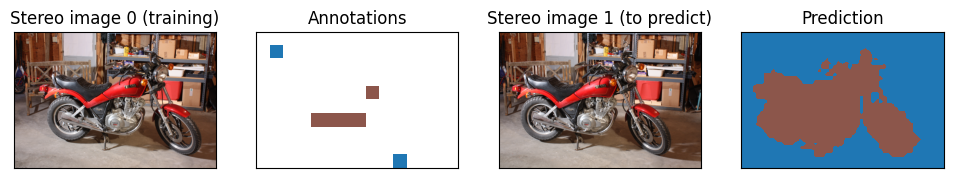

In [ ]:
# Show the image and the annotations
fig, axes = plt.subplots(1, 4, figsize=(12, 8))

# Plot the image
axes[0].imshow(img[0], cmap='gray')
axes[0].set_title(f'Stereo image 0 (training)')

cmap = plt.get_cmap('tab20')
cmap.set_under('white')

# Plot the annotations
axes[1].imshow(annotations, cmap=cmap, interpolation='nearest', vmin=1, vmax=3)
axes[1].set_title('Annotations')

# Plot the image to predict
axes[2].imshow(img[1], cmap='gray')
axes[2].set_title(f'Stereo image 1 (to predict)')


# Plot the prediction
axes[3].imshow(segmentation, cmap=cmap, interpolation='nearest', vmin=1, vmax=3)
axes[3].set_title('Prediction')

# Disable x and y ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

### Visualizing the extracted `DINOv2` features

In [16]:
feature_image = cpm_dino.get_feature_image(train_img)

Extracted 384 features.


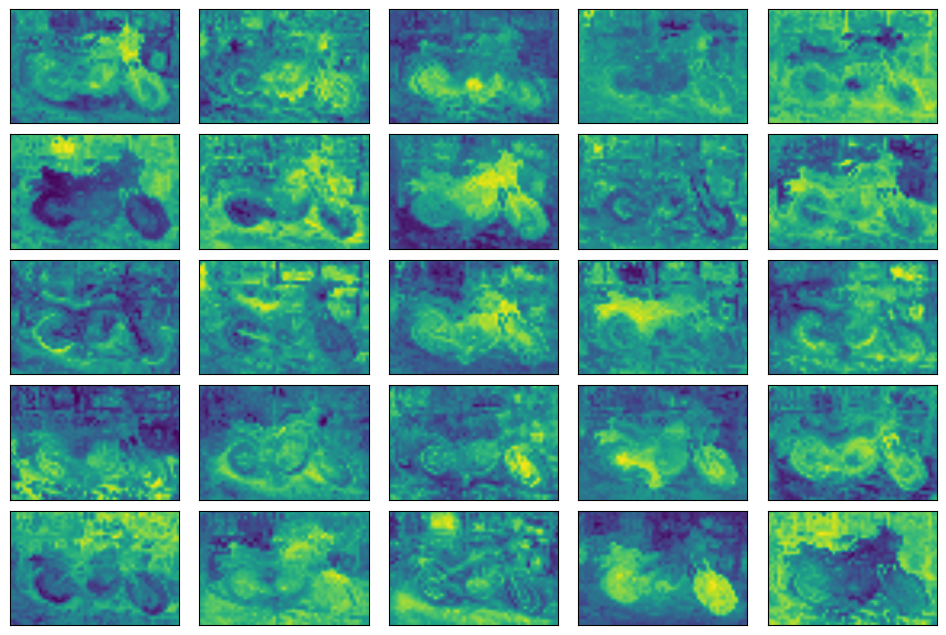

In [17]:
num_features = feature_image.shape[0]
print(f"Extracted {num_features} features.")

grid_size = 5
random_features = np.random.choice(num_features, grid_size*grid_size)
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(feature_image[random_features[i]], cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])
    
# Set w/h distance between subplots to 0
plt.subplots_adjust(wspace=0.1, hspace=0.1)

<div class="alert alert-block alert-info">
<b>Tip:</b> It can be useful to visualize the extracted features for troubleshooting and getting an intuition for the level of detail that the model considers. In this example, DINOv2 extracts high-level semantic features like tires, floor, bike body or engine.

## Combining features from multiple models

The strengths of different feature extractors can be combined by concatenating their outputs. For example, the good spatial resolution of VGG16 can be combined with the rich semantic features of DINOv2. This leads to very successful segmentations on some datasets.

We are providing a selection of pre-defined combo feature extractors. You can use these out of the box or as a starting point for your own custom configurations.

In [24]:
cpm_combo = ConvpaintModel(fe_name="combo_dino_vgg", multi_channel_img=True)

train_img = np.moveaxis(skimage.data.stereo_motorcycle()[0],-1,0)
pred_img = np.moveaxis(skimage.data.stereo_motorcycle()[1],-1,0) 

# Train on the first image
cpm_combo.train(train_img, annotations)

# Predict on the second
segmentation = cpm_combo.segment(pred_img)

C:\Users\roman\Documents\Convpaint\hinderling-cp\napari-convpaint\src\napari_convpaint\conv_paint_model.py:1522: UserWarning: Annotations for image 0 are not of type int. Converting to int32.
  warnings.warn(f'Annotations for image {i} are not of type int. Converting to int32.')


0:	learn: 0.3776222	total: 27.2ms	remaining: 2.69s
1:	learn: 0.2040664	total: 48.8ms	remaining: 2.39s
2:	learn: 0.1180317	total: 68.9ms	remaining: 2.23s
3:	learn: 0.0671248	total: 87.3ms	remaining: 2.1s
4:	learn: 0.0386676	total: 106ms	remaining: 2.01s
5:	learn: 0.0246967	total: 123ms	remaining: 1.93s
6:	learn: 0.0151749	total: 141ms	remaining: 1.87s
7:	learn: 0.0097853	total: 157ms	remaining: 1.81s
8:	learn: 0.0067584	total: 174ms	remaining: 1.76s
9:	learn: 0.0044729	total: 191ms	remaining: 1.72s
10:	learn: 0.0031835	total: 208ms	remaining: 1.68s
11:	learn: 0.0022336	total: 224ms	remaining: 1.64s
12:	learn: 0.0017226	total: 242ms	remaining: 1.62s
13:	learn: 0.0013815	total: 260ms	remaining: 1.6s
14:	learn: 0.0011009	total: 278ms	remaining: 1.57s
15:	learn: 0.0008923	total: 296ms	remaining: 1.56s
16:	learn: 0.0007368	total: 313ms	remaining: 1.53s
17:	learn: 0.0006244	total: 330ms	remaining: 1.5s
18:	learn: 0.0005451	total: 345ms	remaining: 1.47s
19:	learn: 0.0004590	total: 362ms	remain

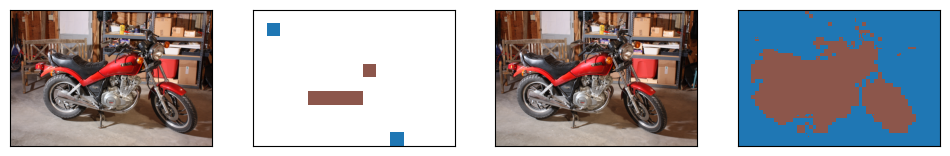

In [25]:
# Show the image and the annotations
fig, axes = plt.subplots(1, 4, figsize=(12, 6))

# Plot the image
axes[0].imshow(img[0], cmap='gray')

cmap = plt.get_cmap('tab20')
cmap.set_under('white')

# Plot the annotations
axes[1].imshow(annotations, cmap=cmap, interpolation='nearest', vmin=1, vmax=3)

# Plot the image to predict
axes[2].imshow(img[1], cmap='gray')

# Plot the prediction
axes[3].imshow(segmentation, cmap=cmap, interpolation='nearest', vmin=1, vmax=3)

# Disable x and y ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

### Visual comparison of features extracted by DINOv2 vs. VGG16

In [26]:
cpm_vgg = ConvpaintModel(fe_name="vgg16", multi_channel_img=True)
features_vgg = cpm_vgg.get_feature_image(train_img)

cpm_dino = ConvpaintModel(fe_name="dinov2_vits14_reg", multi_channel_img=True)
features_dino = cpm_dino.get_feature_image(train_img)

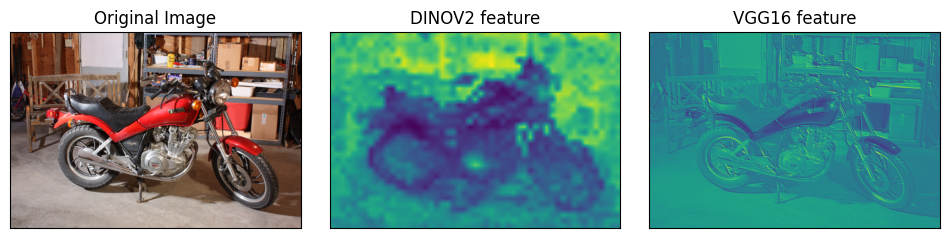

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))

# Plot img, and a random feature each from dinov2 and vgg16
axes[1].imshow(features_dino[22,:,:], cmap='viridis')
axes[1].set_title('DINOV2 feature')
axes[2].imshow(features_vgg[22,:,:], cmap='viridis')
axes[2].set_title('VGG16 feature')
axes[0].imshow(img[0])
axes[0].set_title('Original Image')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(wspace=0.1, hspace=0.1)